# Master's research code draft.
## PAH clustering
### Will be exploring agglomerative/heirarchical clustering on both Spitzer and JWST data; will also compare to results of similar works (ie Boersma 2014).

### Sofia Pasquini

#### Just a draft at the moment, main code developped in github.com/sofiapasquini/PAH-revolution

In [9]:
#import some relevant packages
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score #(?)
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import interpolate

## Pre-processing
### Load in the data and construct the spectra

In [10]:
#load in the data 

folder="/Volumes/LaCie/MASTERS/NGC2023_IRS_Boersma_2016/"
file_name= "NGC2023_SPECTRAL_MAP_SOUTH.fits" #just for now
hdulist = fits.open(folder+file_name)

### Wavelength array

In [11]:
#read the wavelength data and inspect type/shape
wave=hdulist[1].data['wavelength']
print(type(wave))
print(wave.shape)

<class 'numpy.ndarray'>
(1, 194, 1)


In [12]:
#reshape the wavelength array from 3 to 1 dimension
wave=np.reshape(wave, -1)
print(type(wave))
print(wave.shape)

<class 'numpy.ndarray'>
(194,)


In [13]:
#now read in the data and check the type/shape
spectra=hdulist[0].data
print(type(spectra))
print(spectra.shape)

<class 'numpy.ndarray'>
(194, 17, 27)


In [14]:
#we want to rearrange so the dimensions are (x, y, lambda)
spectra = np.moveaxis(np.swapaxes(spectra, 1, 2), 0, 2) 
print(spectra.shape)
print(spectra.shape[0], spectra.shape[1])

(27, 17, 194)
27 17


In [12]:
#make sure to close the file after we are done
hdulist.close()

### Continua

In [13]:
#now we wish to read in the continuum data
file_name='NGC2023_CONTINUUM_MAP_SOUTH.fits'
hdulist=fits.open(folder+file_name)

In [21]:
#first the wavelengths
wave_cont=hdulist[1].data['wavelength']
print(wave_cont.shape)
print(type(wave_cont))

(89046,)
<class 'numpy.ndarray'>


In [22]:
#we now have the wavelength array repeated for each pixel
#we want to reshape such that the wavelength array has the same format as the spectral cube
wave_cont=np.reshape(wave_cont, [27, 17, 194], order='F') #"F" means the first index varies the fastest and the last one the slowest.

(27, 17, 194)


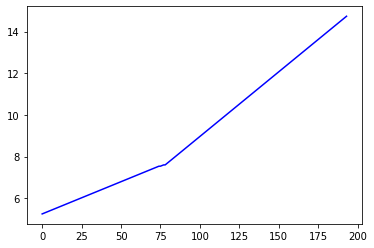

<Figure size 432x288 with 0 Axes>

In [23]:
# make integer array and test result!
test = np.arange(194)
print(wave_cont.shape)
plt.plot(test, wave_cont[10,10,:], color='b')
plt.show()
plt.clf()

In [25]:
#now get the continuum data
cont=hdulist[0].data
print(cont.shape)
print(type(cont))


(194, 17, 27)
<class 'numpy.ndarray'>


In [26]:
#reshape as we did before
cont = np.moveaxis(np.swapaxes(cont, 1, 2), 0, 2)
print(cont.shape)
print(type(cont))

(27, 17, 194)
<class 'numpy.ndarray'>


In [27]:
#close that file
hdulist.close()

### Extinction maps

In [28]:
file_name= 'NGC2023_EXTINCTION_MAPS_SOUTH.fits'
hdulist=fits.open(folder+file_name)

In [29]:
#read in the wavelength array
wave_ext= hdulist[2].data['wavelength']
print(wave_ext.shape)
print(type(wave_ext))

(194,)
<class 'numpy.ndarray'>


In [30]:
#read in the extinction data
ext= hdulist[1].data
print(ext.shape)

(194, 17, 27)


In [31]:
#reshape as we did before
ext = np.moveaxis(np.swapaxes(ext, 1, 2), 0, 2)
print(ext.shape)

(27, 17, 194)


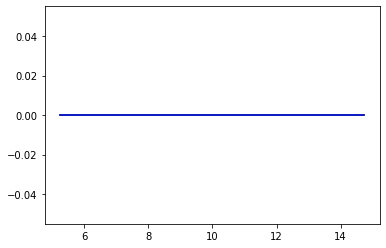

In [32]:
# check if all wavelength arrays are the same ---> Yes!
plt.plot(wave, wave-wave_ext, color='r')
plt.plot(wave, wave-wave_cont[15, 15, :], color='g')
plt.plot(wave, wave_cont[4,4,:]-wave_cont[15, 15, :], color='b')
plt.show()


In [34]:
# #lets plot the spectrum with the corresponding continuum in a pdf

# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('plot_spectra_cont_C.pdf') as pdf:
# 	for i in np.arange(len(spectra[:, 0, 0])):
# 		for j in np.arange(len(spectra[0, :, 0])):
# 			plt.figure(figsize=(3, 3))
# 			plt.plot(wave, spectra[i, j, :], color='b')
# 			plt.plot(wave, cont[i, j, :], color='r')
# 			plt.plot(wave, ext[i,j,:]*100, color='g')
# 			plt.title('('+str(i)+','+str(j)+')')
# 			pdf.savefig()  # saves the current figure into a pdf page
# 			plt.close()

### Extinction Correction + Continuum Fit

In [37]:
#extinction correct the spectra
extcorr_spectra=spectra/ext

In [38]:
#fit a spline continuum

flux = extcorr_spectra[18, 8, :]

#set the anchor points
anchor_ind_init = np.array([4, 10, 42, 57, 107, 115, 121, 145, 166, 178]) #### [5.36, 5.5, 6.54, 7.00, 9.39, 9.89, 10.26, 11.75, 13.06, 13.80]

# find closest wavelengths in wave array

xanchor = wave[anchor_ind_init]    #### <class 'numpy.ndarray'> (also array if you use a list for anchor_ind_init)
yanchor = flux[anchor_ind_init]


In [39]:
#now determine the spline fit
def splinefit(xpoints,ypoints):
  x = np.array(xpoints)
  y = np.array(ypoints)

  # spline interpolation
  tck = interpolate.splrep(x, y, s=0)

  # new wavelength points to evaluate spline
  xnew = np.arange(min(xpoints),max(xpoints),0.001)
  # evaluate spline at new points
  ynew = interpolate.splev(xnew, tck, der=0)

  # plot the spline
  # plt.plot(xnew,ynew,label='continuum')
  # plt.plot(xpoints,ypoints,'ro')
  # plt.show()

  # return
  return tck



In [42]:
spline = splinefit(xanchor, yanchor)
print(type(spline))

<class 'tuple'>


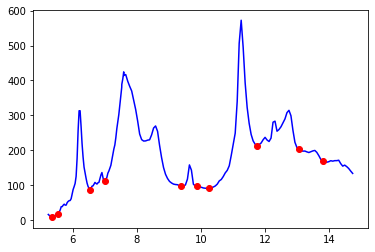

In [43]:
plt.plot(wave, flux, color='b')
plt.plot(xanchor, yanchor, 'ro')
#plt.plot(xanchor, spline, 'g+')
plt.show()


(27, 17, 194)


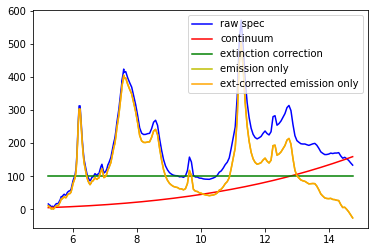

In [47]:
i = 18
j = 8

print(((spectra-cont)/ext).shape)
t=(spectra-cont)
tt=(spectra-cont)/ext
plt.plot(wave, spectra[i, j, :], color='b', label='raw spec')
plt.plot(wave, cont[i, j, :], color='r', label='continuum')
plt.plot(wave, ext[i,j,:]*100, color='g', label='extinction correction')
plt.plot(wave, t[i,j,:], color='y', label='emission only')
plt.plot(wave, tt[i,j,:], color='orange', label='ext-corrected emission only')
plt.legend()
plt.show()


In [48]:
#in the above plot it just happens that the emission only spectrum and the emission only spectrum which has been extinction corrected coincide.


In [23]:
df=np.zeros(shape=(10,5))
print(df)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [25]:
df[1]=[1,2,3,4,5]
print(df)

[[0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [26]:
x=[1,3,7,9,8]
df[2]=x
print(df)

[[0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5.]
 [1. 3. 7. 9. 8.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [1]:
from pre_processing import *
import numpy as np

In [2]:
df=np.random.rand(27, 17, 194)

In [3]:
df=df_create(df)

In [4]:
print(df.shape)

(459, 194)


In [5]:
X=standardize(df)

NameError: name 'scaler' is not defined